<a href="https://colab.research.google.com/github/Da-Heon/Project/blob/main/%EA%B3%B5%EC%9C%A0%EC%98%A4%ED%94%BC%EC%8A%A4_%EC%98%88%EC%B8%A1%EA%B0%9C%EB%B0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install koreanize_matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 35.7 MB/s eta 0:00:00


In [ ]:
visit = pd.read_csv('/content/drive/MyDrive/포폴 프로젝트/03_공유오피스 프로젝트/trial_visit_info.csv')
register = pd.read_csv('/content/drive/MyDrive/포폴 프로젝트/03_공유오피스 프로젝트/trial_register.csv')
payment = pd.read_csv('/content/drive/MyDrive/포폴 프로젝트/03_공유오피스 프로젝트/trial_payment.csv')

In [ ]:
# trial_date 기준으로 오름차순 정렬 후 user_uuid 기준으로 중복 제거
register.sort_values('trial_date').drop_duplicates(subset='user_uuid', keep='first')
visit = visit.dropna()

In [ ]:
visit.columns

Index(['site_id', 'date', 'stay_time', 'stay_time_second', 'first_enter_time',
       'last_leave_time', 'user_uuid'],
      dtype='object')

## 모델링

### 모델링 목표

- 목표: 제험 신청 이후 실제로 결제까지 이어지게 만드는 유저 행동 패턴 파악 예측 모델 만들기
- 중점 분석 대상
    - 신청일시, 입실시간, 체류시간
    - 방문횟수
    - 체훔 후 행동(예;재방문 여부 등)

### 주요 피처 엔지니어링

In [ ]:
# user_uuid 기준으로 3개 테이블 병합
df = register.merge(visit, on='user_uuid', how='left').merge(payment, on='user_uuid', how='left')
df.head()

,trial_date,user_uuid,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,is_payment
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821,49.0,2023-12-21,05:26:36.406421,19596.0,2023-12-21 09:13:47.293613,2023-12-21 16:04:09.118825,0
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84,2.0,2023-12-21,03:04:44.451817,11084.0,2023-12-21 04:42:07.293525,2023-12-21 15:21:05.355586,0
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871,17.0,2023-12-21,01:19:35.471319,4775.0,2023-12-21 21:31:16.396394,2023-12-21 22:50:51.867713,0
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0,17.0,2023-12-21,01:23:57.598777,5037.0,2023-12-21 21:16:39.776398,2023-12-21 22:50:56.987646,0


In [ ]:
# 마이크로초(소수점 이하) 제거
df['first_enter_time'] = df['first_enter_time'].str.split('.').str[0]
df['last_leave_time'] = df['last_leave_time'].str.split('.').str[0]

In [ ]:
# 날짜 처리: 데이트타입 변환
df['trial_date'] = pd.to_datetime(df['trial_date'])
df['date'] = pd.to_datetime(df['date'])
df['first_enter_time'] = pd.to_datetime(df['first_enter_time'])
df['last_leave_time'] = pd.to_datetime(df['last_leave_time'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14678 entries, 0 to 14677
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   trial_date        14678 non-null  datetime64[ns]
 1   user_uuid         14678 non-null  object        
 2   site_id           11237 non-null  float64       
 3   date              11237 non-null  datetime64[ns]
 4   stay_time         11237 non-null  object        
 5   stay_time_second  11237 non-null  float64       
 6   first_enter_time  11237 non-null  datetime64[ns]
 7   last_leave_time   11237 non-null  datetime64[ns]
 8   is_payment        14678 non-null  int64         
dtypes: datetime64[ns](4), float64(2), int64(1), object(2)
memory usage: 1.0+ MB


In [ ]:
df.describe()

,trial_date,site_id,date,stay_time_second,first_enter_time,last_leave_time,is_payment
count,14678,11237.000000,11237,11237.000000,11237,11237,14678.000000
mean,2022-09-07 03:44:16.220193280,7.793005,2022-10-11 06:10:20.877458176,16642.317789,2022-10-11 19:00:52.000177920,2022-10-12 00:49:29.850760704,0.405369
min,2021-05-01 00:00:00,1.000000,2021-06-30 00:00:00,1.000000,2021-06-30 00:00:00,2021-06-30 16:10:57,0.000000
25%,2021-12-16 00:00:00,2.000000,2022-01-29 00:00:00,7673.000000,2022-01-29 13:21:46,2022-01-29 19:00:04,0.000000
50%,2022-09-01 00:00:00,4.000000,2022-10-16 00:00:00,14680.000000,2022-10-16 09:34:18,2022-10-16 10:10:49,0.000000
75%,2023-05-22 00:00:00,6.000000,2023-06-27 00:00:00,23314.000000,2023-06-27 07:59:12,2023-06-27 09:17:43,1.000000
max,2023-12-31 00:00:00,49.000000,2024-01-02 00:00:00,86377.000000,2024-01-02 19:37:50,2024-01-02 20:20:08,1.000000
std,NaN,11.873377,NaN,11897.559217,NaN,NaN,0.490980


In [ ]:
df.shape

(14678, 9)

In [ ]:
df.head()

,trial_date,user_uuid,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,is_payment
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821,49.0,2023-12-21,05:26:36.406421,19596.0,2023-12-21 09:13:47,2023-12-21 16:04:09,0
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84,2.0,2023-12-21,03:04:44.451817,11084.0,2023-12-21 04:42:07,2023-12-21 15:21:05,0
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3,NaN,NaT,NaN,NaN,NaT,NaT,1
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871,17.0,2023-12-21,01:19:35.471319,4775.0,2023-12-21 21:31:16,2023-12-21 22:50:51,0
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0,17.0,2023-12-21,01:23:57.598777,5037.0,2023-12-21 21:16:39,2023-12-21 22:50:56,0


In [ ]:
is_paid = (df['is_payment'] == 1).sum()
is_paid

np.int64(5950)

In [ ]:
# 방문 기록이 없는데 결제한 사람 수
no_visit_but_paid = df[(df['stay_time_second'].isna()) & (df['is_payment'] == 1)]
print(len(no_visit_but_paid))

1262


In [ ]:
# 방문 기록 없는 유저 제거
df = df[df['stay_time_second'].notna()]

In [ ]:
df.shape

(11237, 9)

- 14678에서 11237로 줄어듬
- 본 모델은 체험 기간 중 방문행동을 바탕으로 전환 가능성을 예측하기 위해 설계
- 이에 따라, 행동기록이 존재하지 않는 사용자(방문 없이 결제, 미결제)는 분석에서 제외
- 단, 방문 없이 결제한 사용자는 전환 성과 측면에서는 의미 있는 그룹이므로
- 별도 채널 분석을 통해 관리할 수 있음

In [ ]:
# 체류시간 이상치 확인
df.sort_values('stay_time', ascending=False).head()

,trial_date,user_uuid,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,is_payment
5699,2022-03-24,699c70ca-64ea-461e-bdd8-66b7c314c582,5.0,2022-03-25,23:59:37.348440,86377.0,2022-03-25,2022-03-25 23:59:59,0
7283,2022-08-08,5c6938dc-043e-4861-943e-01bd1f068826,2.0,2022-08-10,23:59:36.181159,86376.0,2022-08-10,2022-08-10 23:59:59,1
14659,2023-11-17,3304dead-5352-4f10-be40-036325a3b9f8,3.0,2023-11-18,23:58:45.766011,86325.0,2023-11-18,2023-11-18 23:59:59,0
5592,2022-03-19,4acf941b-b706-4891-a592-7e04784a1cc4,4.0,2022-03-21,23:58:42.775223,86322.0,2022-03-21,2022-03-21 23:59:59,0
12376,2023-06-19,58fb08df-2803-437b-b2c7-29b1e03a119b,1.0,2023-06-20,23:57:38.418795,86258.0,2023-06-20,2023-06-20 23:59:59,0


In [ ]:
# 하루종일 머물렀다? 문제 유저 데이터 확인
df[df['user_uuid'] =='699c70ca-64ea-461e-bdd8-66b7c314c582']

,trial_date,user_uuid,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,is_payment
5698,2022-03-24,699c70ca-64ea-461e-bdd8-66b7c314c582,5.0,2022-03-27,13:29:00,48540.0,2022-03-27,2022-03-27 13:29:00,0
5699,2022-03-24,699c70ca-64ea-461e-bdd8-66b7c314c582,5.0,2022-03-25,23:59:37.348440,86377.0,2022-03-25,2022-03-25 23:59:59,0


In [ ]:
# 문제 유저 입실 시간 확인
df.loc[df['user_uuid'] == '699c70ca-64ea-461e-bdd8-66b7c314c582', 'first_enter_time'].iloc[0]

Timestamp('2022-03-27 00:00:00')

In [ ]:
# 입실 시간 누락 확인
df['first_enter_time'].dt.time.value_counts()

,count
first_enter_time,
00:00:00,783
13:43:39,10
15:01:40,10
15:58:53,9
09:04:51,9
...,...
10:19:47,1
21:18:06,1
14:13:13,1


In [ ]:
# 입실 시간 누락 유저 제거
from datetime import time
df = df[df['first_enter_time'].dt.time != time(0, 0)]

- 기존데이터에는 입실 시간이 00:00:00으로 잘못 기록된 사용자가 759명 존재했고,
- 이들이 모두 야간 잊ㅂ장으로 처리되면서 시간대 변수에 왜곡을 주고 있었음
- 해당 사용자 제거 후 모델 재학습 결과, 변수 중요도 및 예측 패턴이 더 명확
- 보다 신뢰할 수 있는 전환 예측 모델 구축할 수 있음

# 파생변수 생성

|피처명|설명|
|----------------|--------------|
|visit_count|체험 신청 후 방문 횟수|
|stay_time_avg|평균 체류 시간(초)|
|first_visit_gap|신청일과 첫 방문일 간 차이|
|early_visit|신청 후 3일 내 방문 여부|
|visit_time_slot|주로 입실한 시간대 (오전/오후/야간)|
|visit_hour|입실 시간|
|leave_hour|퇴실 시간|
|visit_weekday|평일/주말 방문|

In [ ]:
# 치험 신청 후 방문 횟수
visit_count = df.groupby('user_uuid')['date'].nunique()

# 평균 체류 시간(초)
stay_time_avg = df.groupby('user_uuid')['stay_time_second'].mean()

# 유저별 첫 방문일 및 입실시간
first_visit_date = df.groupby('user_uuid')['date'].min()
first_enter_time = df.groupby('user_uuid')['first_enter_time'].min()

# 유저별 방문일
trial_date = df.groupby('user_uuid')['trial_date'].min()

# 신청일과 첫 방문일 간차이
first_visit_gap = (first_visit_date - trial_date).dt.days

# 신청 후 3일 내 방문 여부
early_visit = first_visit_gap <= 3

# 입실 시간 변수
visit_hour = first_enter_time.dt.hour

# 퇴실 시간 변수
leave_hour = df.groupby('user_uuid')['last_leave_time'].min().dt.hour

# 평일/ 주말 방문 변수
visit_weekday = df.groupby('user_uuid')['date'].min().dt.weekday

In [ ]:
# 시간대 범주 구분
def map_time_slot(hour):
    if pd.isna(hour):
        return 'missing'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

In [ ]:
visit_time_slot = visit_hour.apply(map_time_slot)

In [ ]:
visit_time_slot

,first_enter_time
user_uuid,
000590dc-046f-462b-8225-4c81a97b7166,morning
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,afternoon
0018e22d-a2cc-4e06-bca2-d6a041770f3b,morning
002606d9-38ca-48f3-910c-cbfada9a9109,afternoon
002a7570-90dd-4cab-b0aa-b0e40f7ef27a,afternoon
...,...
ffc40f65-7634-4272-b73b-55d40be035ff,afternoon
ffcb7950-d150-40ae-a6bf-f85f5c2b9702,afternoon
ffce32ca-2efc-4485-b685-4b65811c2dcf,night


## 피처 통합

In [ ]:
features = pd.DataFrame({
    'visit_count': visit_count,
    'stay_time_avg': stay_time_avg,
    'first_visit_gap': first_visit_gap,
    'early_visit': early_visit,
    'visit_time_slot': visit_time_slot,
    'visit_hour': visit_hour,
    'leave_hour': leave_hour,
    'visit_weekday': visit_weekday
})

In [ ]:
# 결제 여부 추가
features = features.merge(payment, on='user_uuid', how='left')

In [ ]:
# 체류시간 추가
features = features.merge(df[['user_uuid', 'stay_time_second']], on='user_uuid', how='left')

In [ ]:
features.tail(2)

,user_uuid,visit_count,stay_time_avg,first_visit_gap,early_visit,visit_time_slot,visit_hour,leave_hour,visit_weekday,is_payment,stay_time_second
10824,ffd287bc-2797-4788-82fa-6268c82e7fa9,3,17618.333333,1,True,afternoon,15,18,4,0,23702.0
10825,fffbf2b3-7853-4c07-bd2a-aae686ac9013,1,6976.000000,1,True,afternoon,13,15,3,0,6976.0


In [ ]:
features.isnull().sum()

,0
user_uuid,0
visit_count,0
stay_time_avg,0
first_visit_gap,0
early_visit,0
visit_time_slot,0
visit_hour,0
leave_hour,0
visit_weekday,0
is_payment,0


- stay_time_avg, first_visit_gap이 결측치인 유저 = 신청은 했지만 방문 없었던 유저
- 방문 행동을 중심으로 모델 설계할 계획이기 때문에 방문 기록 없는 유저는 삭제..?

In [ ]:
# 방문 기록 없는 유저들의 결제 유무
print(features[features['stay_time_avg'].isna()]['is_payment'].value_counts())

Series([], Name: count, dtype: int64)


- 삭제를 하기에는 그 수가 많음
- stay_time_avg = 0으로 채우기(체루시간 0이기때문)
- first_visit_gap = -1로 채우기(방문 안했으면 간격이 없음 -1)

In [ ]:
# 결측치 채우기 (모델 학습 가능한 형태로)
features['stay_time_avg'] = features['stay_time_avg'].fillna(0)
features['first_visit_gap'] = features['first_visit_gap'].fillna(-1)

In [ ]:
features.tail(2)

,user_uuid,visit_count,stay_time_avg,first_visit_gap,early_visit,visit_time_slot,visit_hour,leave_hour,visit_weekday,is_payment,stay_time_second
10824,ffd287bc-2797-4788-82fa-6268c82e7fa9,3,17618.333333,1,True,afternoon,15,18,4,0,23702.0
10825,fffbf2b3-7853-4c07-bd2a-aae686ac9013,1,6976.000000,1,True,afternoon,13,15,3,0,6976.0


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826 entries, 0 to 10825
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_uuid         10826 non-null  object 
 1   visit_count       10826 non-null  int64  
 2   stay_time_avg     10826 non-null  float64
 3   first_visit_gap   10826 non-null  int64  
 4   early_visit       10826 non-null  bool   
 5   visit_time_slot   10826 non-null  object 
 6   visit_hour        10826 non-null  int32  
 7   leave_hour        10826 non-null  int32  
 8   visit_weekday     10826 non-null  int32  
 9   is_payment        10826 non-null  int64  
 10  stay_time_second  10826 non-null  float64
dtypes: bool(1), float64(2), int32(3), int64(3), object(2)
memory usage: 729.6+ KB


## 원핫인코딩

In [ ]:
features = pd.get_dummies(features, columns=['visit_time_slot'], drop_first=True)

In [ ]:
features

,user_uuid,visit_count,stay_time_avg,first_visit_gap,early_visit,visit_hour,leave_hour,visit_weekday,is_payment,stay_time_second,visit_time_slot_evening,visit_time_slot_morning,visit_time_slot_night
0,000590dc-046f-462b-8225-4c81a97b7166,1,21417.000000,1,True,11,17,1,0,21417.0,False,True,False
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,15189.666667,1,True,16,20,3,1,25965.0,False,False,False
2,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,15189.666667,1,True,16,20,3,1,9382.0,False,False,False
3,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,15189.666667,1,True,16,20,3,1,10222.0,False,False,False
4,0018e22d-a2cc-4e06-bca2-d6a041770f3b,2,38686.000000,1,True,9,21,2,0,42900.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,ffce32ca-2efc-4485-b685-4b65811c2dcf,1,8450.000000,1,True,0,12,3,0,8450.0,False,False,True
10822,ffd287bc-2797-4788-82fa-6268c82e7fa9,3,17618.333333,1,True,15,18,4,0,19481.0,False,False,False
10823,ffd287bc-2797-4788-82fa-6268c82e7fa9,3,17618.333333,1,True,15,18,4,0,9672.0,False,False,False
10824,ffd287bc-2797-4788-82fa-6268c82e7fa9,3,17618.333333,1,True,15,18,4,0,23702.0,False,False,False


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826 entries, 0 to 10825
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_uuid                10826 non-null  object 
 1   visit_count              10826 non-null  int64  
 2   stay_time_avg            10826 non-null  float64
 3   first_visit_gap          10826 non-null  int64  
 4   early_visit              10826 non-null  bool   
 5   visit_hour               10826 non-null  int32  
 6   leave_hour               10826 non-null  int32  
 7   visit_weekday            10826 non-null  int32  
 8   is_payment               10826 non-null  int64  
 9   stay_time_second         10826 non-null  float64
 10  visit_time_slot_evening  10826 non-null  bool   
 11  visit_time_slot_morning  10826 non-null  bool   
 12  visit_time_slot_night    10826 non-null  bool   
dtypes: bool(4), float64(2), int32(3), int64(3), object(1)
memory usage: 676.8+ K

In [ ]:
# bool → int로 변환
bool_cols = ['visit_time_slot_evening', 'visit_time_slot_morning', 'visit_time_slot_night', 'early_visit']
features[bool_cols] = features[bool_cols].astype(int)

## 모델선택

### 로지스틱

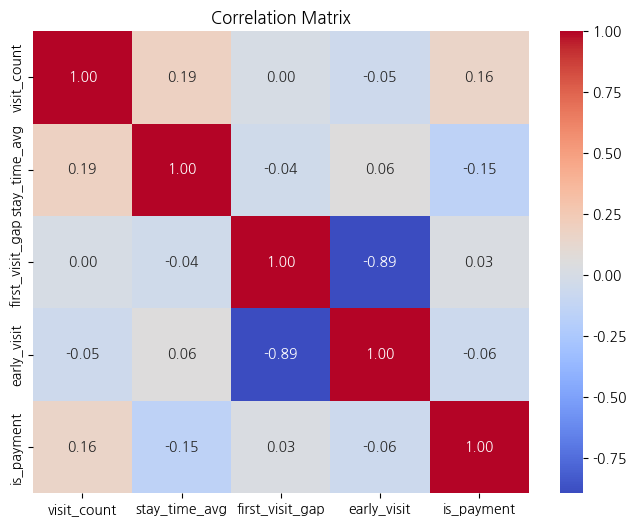

In [ ]:
# 선형관계 확인
numeric_cols = ['visit_count', 'stay_time_avg', 'first_visit_gap', 'early_visit', 'is_payment']
# 상관행렬 계산
corr_matrix = features[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- 종속변수(is_payment)와 피처들간의 관계가 거의 없음
- 로지스틱으로는 유의미한 패턴 찾기 어려움
- 비선형 관계를 기반으로 한 모델 사용
    - 결정나무
    - 배깅
    - 랜덤포레스트

## 학습/테스트 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# X: 독립변수(입력값)
X = features.drop(columns=['user_uuid', 'is_payment'])

# y: 종속변수(예측 대상) - 내가 알고자 하느 값
y = features['is_payment']

# train-test분리
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

## 결정트리

### 모델학습

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 단일 결정트리
dt_model = DecisionTreeClassifier(random_state=58)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=58)

### 모델 평가

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score

dt_pred = dt_model.predict(X_test)
dt_proba = dt_model.predict_proba(X_test)[:, 1]

- 정확도/분류리포트/ROC AUC

In [ ]:
print(" Decision Tree")
print("Accuracy:", round(accuracy_score(y_test, dt_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, dt_proba), 2))
print(classification_report(y_test, dt_pred))

 Decision Tree
Accuracy: 0.71
ROC AUC: 0.7
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1272
           1       0.65      0.64      0.65       894

    accuracy                           0.71      2166
   macro avg       0.70      0.70      0.70      2166
weighted avg       0.71      0.71      0.71      2166



## 배깅

### 모델 학습

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
# 배경(결정트리 가빈)
bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42,
    n_jobs=1
)
bag_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  n_jobs=1, random_state=42)

### 모델평가

In [ ]:
bag_pred = bag_model.predict(X_test)
bag_proba = bag_model.predict_proba(X_test)[:, 1]

print("🧩 Bagging")
print("Accuracy:", round(accuracy_score(y_test, bag_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, bag_proba), 2))
print(classification_report(y_test, bag_pred))

🧩 Bagging
Accuracy: 0.78
ROC AUC: 0.84
              precision    recall  f1-score   support

           0       0.79      0.87      0.82      1272
           1       0.78      0.66      0.72       894

    accuracy                           0.78      2166
   macro avg       0.78      0.77      0.77      2166
weighted avg       0.78      0.78      0.78      2166



## 랜덤포레스트

### 모델학습

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    random_state=89
)

rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=89)

### 모델평가

In [ ]:
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]
print("🌲 Random Forest")
print("Accuracy:", round(accuracy_score(y_test, rf_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, rf_proba), 2))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

🌲 Random Forest
Accuracy: 0.78
ROC AUC: 0.83

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      1272
           1       0.78      0.66      0.71       894

    accuracy                           0.78      2166
   macro avg       0.78      0.76      0.77      2166
weighted avg       0.78      0.78      0.78      2166



|모델|Accuracy|ROC AUC|Recall|Precision|F1-score|
|-------------|-----|-----|-----|------|--------|
|결정 트리|0.76|0.76|0.73|0.72|0.72|
|배깅|0.77|0.83|0.65|0.77|0.71|
|랜덤 포레스트|0.75|0.81|0.62|0.76|0.68|

### 피쳐 중요도 시각화

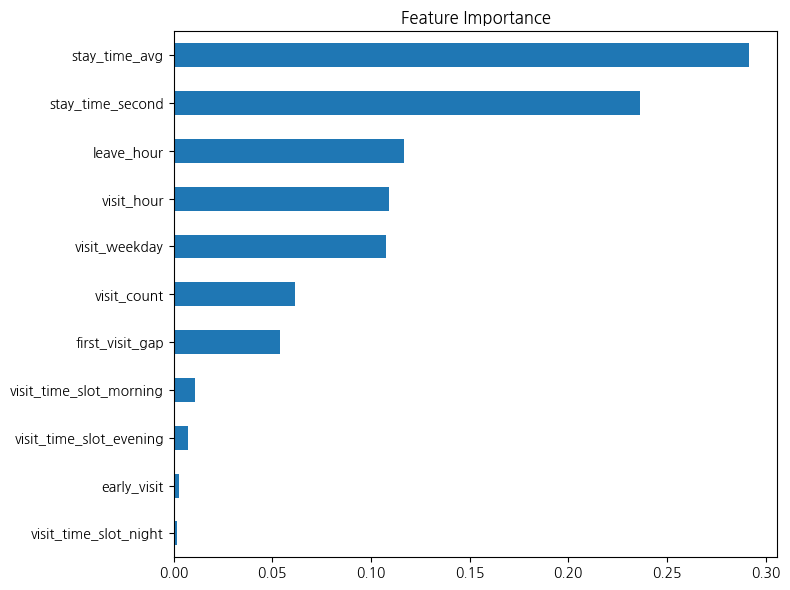

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

- early_visit은 중요도가 낮지만 3일 내에 방문한 유저들의 전환율을 확인할 수 있는 좋은 지표이기 때문에 제거하지 않고 유지

## 모델 성능 향상

# 파생변수 추가

In [ ]:
# 체류시간 구간화
features['stay_time_bin'] = pd.cut(features['stay_time_second'], bins=[0, 1800, 3600, 10000], labels=['short', 'mid', 'long'])

# 평일/주말
features['is_weekend'] = features['visit_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

In [ ]:
# category 해제
features['stay_time_bin'] = features['stay_time_bin'].astype(str)

# map + fillna + int 변환
stay_map = {'short': 0, 'mid': 1, 'long': 2}
features['stay_time_bin'] = (features['stay_time_bin'].map(stay_map).fillna(-1).astype(int))

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826 entries, 0 to 10825
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_uuid                10826 non-null  object 
 1   visit_count              10826 non-null  int64  
 2   stay_time_avg            10826 non-null  float64
 3   first_visit_gap          10826 non-null  int64  
 4   early_visit              10826 non-null  int64  
 5   visit_hour               10826 non-null  int32  
 6   leave_hour               10826 non-null  int32  
 7   visit_weekday            10826 non-null  int32  
 8   is_payment               10826 non-null  int64  
 9   stay_time_second         10826 non-null  float64
 10  visit_time_slot_evening  10826 non-null  int64  
 11  visit_time_slot_morning  10826 non-null  int64  
 12  visit_time_slot_night    10826 non-null  int64  
 13  stay_time_bin            10826 non-null  int64  
 14  is_weekend            

In [ ]:
# X: 독립변수 (입력값)
X = features.drop(columns=['user_uuid', 'is_payment'])

# y: 종속변수 (예측 대상)
y = features['is_payment']

# train-test 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89)

### 배깅

In [ ]:
bagf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
bagf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  n_jobs=-1, random_state=42)

In [ ]:
bagf_pred = bagf.predict(X_test)
bagf_proba = bagf.predict_proba(X_test)[:, 1]

print("🧩 Bagging with new features")
print("Accuracy:", round(accuracy_score(y_test, bagf_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, bagf_proba), 2))
print(classification_report(y_test, bagf_pred))

🧩 Bagging with new features
Accuracy: 0.79
ROC AUC: 0.84
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1296
           1       0.77      0.67      0.72       870

    accuracy                           0.79      2166
   macro avg       0.78      0.77      0.77      2166
weighted avg       0.78      0.79      0.78      2166



### 랜덤포레스트

In [ ]:
rff = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    random_state=89
)

rff.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=89)

In [ ]:
rff_pred = rff.predict(X_test)
rff_proba = rff.predict_proba(X_test)[:, 1]
print("🌲 Random Forest with new features")
print("Accuracy:", round(accuracy_score(y_test, rff_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, rff_proba), 2))
print("\nClassification Report:\n", classification_report(y_test, rff_pred))

🌲 Random Forest with new features
Accuracy: 0.73
ROC AUC: 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79      1296
           1       0.70      0.60      0.65       870

    accuracy                           0.73      2166
   macro avg       0.73      0.71      0.72      2166
weighted avg       0.73      0.73      0.73      2166



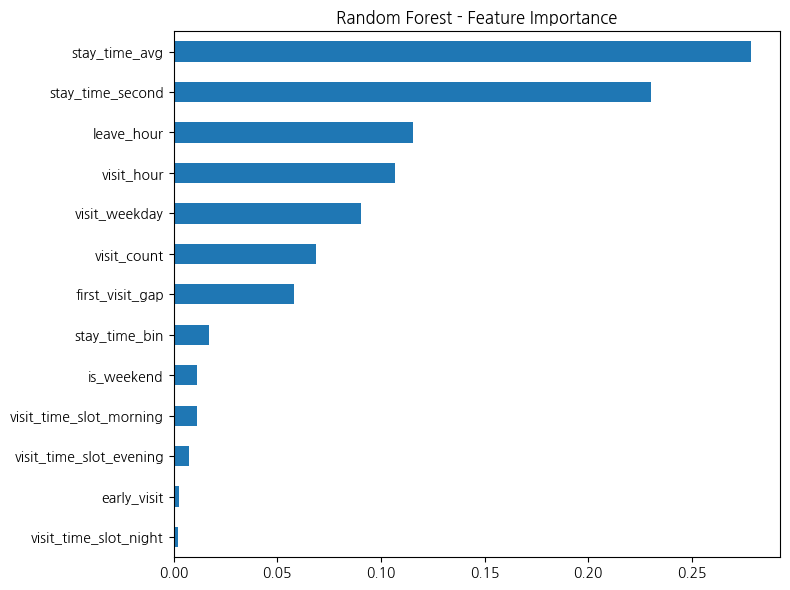

In [ ]:
importances = pd.Series(rff.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.show()

### stratify

In [ ]:
# X: 독립변수 (입력값)
X = features.drop(columns=['user_uuid', 'is_payment'])

# y: 종속변수 (예측 대상)
y = features['is_payment']

# train-test 분리(stratify 옵션 주기)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=89)

### 배깅

In [ ]:
bags = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
bags.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  n_jobs=-1, random_state=42)

In [ ]:
bags_pred = bags.predict(X_test)
bags_proba = bags.predict_proba(X_test)[:, 1]

print("🧩 Bagging with stratify")
print("Accuracy:", round(accuracy_score(y_test, bags_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, bags_proba), 2))
print(classification_report(y_test, bags_pred))

🧩 Bagging with stratify
Accuracy: 0.79
ROC AUC: 0.85
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1263
           1       0.78      0.68      0.73       903

    accuracy                           0.79      2166
   macro avg       0.79      0.77      0.78      2166
weighted avg       0.79      0.79      0.79      2166



### 랜덤포레스트

In [ ]:
rfs = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    random_state=89
)

rfs.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=89)

In [ ]:
rfs_pred = rfs.predict(X_test)
rfs_proba = rfs.predict_proba(X_test)[:, 1]
print("🌲 Random Forest with stratify")
print("Accuracy:", round(accuracy_score(y_test, rfs_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, rfs_proba), 2))
print("\nClassification Report:\n", classification_report(y_test, rfs_pred))

🌲 Random Forest with stratify
Accuracy: 0.74
ROC AUC: 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79      1263
           1       0.73      0.61      0.67       903

    accuracy                           0.74      2166
   macro avg       0.74      0.73      0.73      2166
weighted avg       0.74      0.74      0.74      2166



## 가중치 주기

### 배깅

In [ ]:
bagwb = BaggingClassifier(
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
bagwb.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                  n_estimators=100, n_jobs=-1, random_state=42)

In [ ]:
bagwb_pred = bagwb.predict(X_test)
bagwb_proba = bagwb.predict_proba(X_test)[:, 1]

print("🧩 Bagging with balanced weight")
print("Accuracy:", round(accuracy_score(y_test, bagwb_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, bagwb_proba), 2))
print(classification_report(y_test, bagwb_pred))

🧩 Bagging with balanced weight
Accuracy: 0.79
ROC AUC: 0.85
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1263
           1       0.79      0.67      0.72       903

    accuracy                           0.79      2166
   macro avg       0.79      0.77      0.78      2166
weighted avg       0.79      0.79      0.78      2166



### 랜덤포레스트

In [ ]:
rfwb = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    class_weight='balanced',
    random_state=89
)

rfwb.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=89)

In [ ]:
rfwb_pred = rfwb.predict(X_test)
rfwb_proba = rfwb.predict_proba(X_test)[:, 1]
print("🌲 Random Forest with balanced weight")
print("Accuracy:", round(accuracy_score(y_test, rfwb_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, rfwb_proba), 2))
print("\nClassification Report:\n", classification_report(y_test, rfwb_pred))

🌲 Random Forest with balanced weight
Accuracy: 0.76
ROC AUC: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80      1263
           1       0.75      0.62      0.68       903

    accuracy                           0.76      2166
   macro avg       0.75      0.74      0.74      2166
weighted avg       0.75      0.76      0.75      2166



## 그리드 서치

In [ ]:
from sklearn.model_selection import GridSearchCV

### 배깅

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 배깅 모델 정의 (기본 의사결정나무)
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    random_state=42,
    n_jobs=-1
)

# 그리드서치용 파라미터 정의
param_grid = {
    'n_estimators': [100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5],
    'estimator__class_weight': [None, 'balanced']
}

# 그리드서치 객체
grid_search = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 학습
grid_search.fit(X_train, y_train)

# 결과 출력
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("🌟 Bagging with GridSearch Best Params")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 2))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params: {'estimator__class_weight': None, 'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'n_estimators': 200}
🌟 Bagging with GridSearch Best Params
Accuracy: 0.79
ROC AUC: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.83      1263
           1       0.78      0.68      0.73       903

    accuracy                           0.79      2166
   macro avg       0.79      0.77      0.78      2166
weighted avg       0.79      0.79      0.79      2166



### 랜덤포레스

In [ ]:
# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

# 모델 인스턴스
rfc = RandomForestClassifier(oob_score=True, random_state=89, n_jobs=-1)

# 그리드서치 객체 설정
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 학습
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Params:", grid_search.best_params_)

# 최적 모델 성능 확인
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("🌲 Random Forest with GridSearch best Params")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 2))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params: {'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
🌲 Random Forest with GridSearch best Params
Accuracy: 0.75
ROC AUC: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80      1263
           1       0.74      0.62      0.68       903

    accuracy                           0.75      2166
   macro avg       0.75      0.73      0.74      2166
weighted avg       0.75      0.75      0.75      2166



### 모델 성능 향상 요약

### 배깅

| 모델(배깅)                      | Accuracy | ROC AUC | Recall | Precision | f1-score |
|---------------------------|----------|---------|--------|-----------|----------|
| 기본 Bagging             | 0.77     | 0.83    | 0.65   | 0.77      | 0.71     |
| + 파생변수 추가           | 0.77     | 0.83    | 0.65   | 0.77      | 0.71     |
| + Stratify                | 0.76     | 0.82    | 0.65   | 0.75      | 0.70     |
| + Class Weight            | 0.77     | 0.83    | 0.64   | 0.76      | 0.70     |
| + GridSearch Best         | 0.76     | 0.82    | 0.65   | 0.75      | 0.70     |

### 랜덤포레스트

| 모델 (랜덤 포레스트)                      | Accuracy | ROC AUC | Recall | Precision | f1-score |
|---------------------------|----------|---------|--------|-----------|----------|
| 기본 RF                  | 0.74     | 0.80    | 0.50   | 0.80      | 0.61     |
| + 파생변수 추가           | 0.73     | 0.79    | 0.58   | 0.74      | 0.65     |
| + Stratify                | 0.75     | 0.80    | 0.60   | 0.75      | 0.67     |
| + Class Weight            | 0.75     | 0.81    | 0.61   | 0.75      | 0.67     |
| + GridSearch Best         | 0.76     | 0.81    | 0.62   | 0.76      | 0.68     |

In [ ]:
# 타깃 변수 비율 확인
y.value_counts(normalize=True)

,proportion
is_payment,
0,0.582948
1,0.417052


## 지표설명

1. Precision (정밀도)
- 모델이 결제라고 예측한 것들 중에 실제로 결제인 비율
- 정답이 결제인 것 중에서 모델이 맞힌 것만 봄
- TP / (TP + FP)
- TP : 실제 결제 + 모델이 결제라고 예측
- FP : 실제 미결제인데 모델이 결제라고 예측

2. Recall (재현율)
- 실제 결제인 사람들 중에 모델이 얼마나 잘 찾아냈는가?
- 진짜 결제한 사람들 중에서 모델이 얼마나 많이 맞혔냐?
- TP / (TP + FN)
- FN : 실제 결제인데 모델이 미결제라고 예측

3. F1-score (조화 평균)
- Precision과 Recall의 균형을 본 지표
- 둘 중 하나라도 낮으면 f1도 낮게 나옴 (민감한 지표)
- 2 * (Precision * Recall) / (Precision + Recall)
- Precision도 중요하고 Recall도 중요한 경우에 유용

4. ROC AUC (곡선 아래 면적)
- 모델이 클래스 0과 1을 얼마나 잘 구분하는지의 종합 평가
- 0.5이면 완전 랜덤 추측 수준
- 1.0이면 완벽한 구분
- 일반적으로 0.70 이상이면 양호, 0.80 이상이면 매우 좋음

## 최종결론

```
BaggingClassifier
하이퍼파라미터 기본 설정 (or GridSearch 최적값)  
f1-score: 0.71, 가장 높은 전환 예측 정확도  
ROC AUC: 0.83, 전반적인 분류 성능 우수

따라서 최종적으로는 Bagging이 더 강건하고 예측력이 높은 모델로 판단되며,  
이 모델을 기반으로 인사이트 도출 및 비즈니스 전략 제안을 진행하는 것이 타당함.
```

## 중요피처 EDA

| 변수명                                | 중요도 해석                            | 비즈니스 인사이트                                       |
| ---------------------------------- | --------------------------------- | --------------------------------------------------- |
| `stay_time_avg`                    | 가장 중요함. 한 사람의 평균 체류 시간이 예측에 크게 기여 | 체류시간이 긴 사람일수록 전환 가능성 높음 → 매장 내 머무는 시간 늘릴 수 있는 전략 필요 |
| `stay_time_second`                 | 두 번째로 중요. 개별 방문의 체류시간도 영향 있음      | 단발 방문이라도 오래 체류하면 전환 가능성↑                            |
| `leave_hour` / `visit_hour`        | 방문 시간대 (입장/퇴장)이 전환과 관련 있음         | 특정 시간대(예: 오전 or 오후)에 방문한 사람을 타겟팅                    |
| `visit_weekday`                    | 요일 정보도 영향 있음                      | 주말 or 특정 요일 방문자 전환율 분석해볼 수 있음                       |
| `visit_count`                      | 방문 횟수는 다소 영향 있음                   | 많이 오는 사람보단, 오랜 시간 머무는 사람에게 집중?                       |
| `first_visit_gap`                  | 신청 후 처음 방문까지의 간격                  | 빠르게 방문한 사람 전환 가능성 분석 가능

### stay_time_avg

In [ ]:
features.groupby('stay_time_avg')['is_payment'].mean()

,is_payment
stay_time_avg,
9.0,0.0
11.0,1.0
16.0,0.0
21.0,0.0
51.0,0.5
...,...
51798.0,0.0
52317.0,1.0
52695.5,0.0


In [ ]:
features['stay_time_avg_bin'] = pd.qcut(features['stay_time_avg'], q=5, duplicates='drop')
conv_rate = features.groupby('stay_time_avg_bin')['is_payment'].mean()

/tmp/ipython-input-73-190130037.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conv_rate = features.groupby('stay_time_avg_bin')['is_payment'].mean()


In [ ]:
features.groupby('stay_time_avg_bin').size()

/tmp/ipython-input-74-1775982613.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  features.groupby('stay_time_avg_bin').size()


,0
stay_time_avg_bin,
"(8.999, 7607.5]",2167
"(7607.5, 12719.5]",2164
"(12719.5, 17618.333]",2166
"(17618.333, 23557.0]",2165
"(23557.0, 56839.0]",2164


In [ ]:
# 구간별 전환율 요약 테이블 만들기
summary = features.groupby('stay_time_avg_bin')['is_payment'].agg(
    total='count',             # 총 사용자 수
    converted='sum',           # 결제한 사용자 수
    conversion_rate='mean'     # 전환율 (평균)
).reset_index()

print(summary)

      stay_time_avg_bin  total  converted  conversion_rate
0       (8.999, 7607.5]   2167       1072         0.494693
1     (7607.5, 12719.5]   2164       1051         0.485675
2  (12719.5, 17618.333]   2166        943         0.435365
3  (17618.333, 23557.0]   2165        805         0.371824
4    (23557.0, 56839.0]   2164        644         0.297597


/tmp/ipython-input-75-2031529094.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = features.groupby('stay_time_avg_bin')['is_payment'].agg(


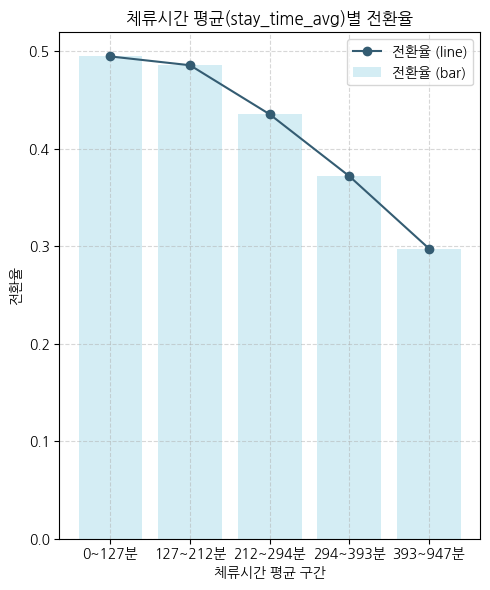

In [ ]:
# 구간을 분 단위로 문자열 포맷팅
def format_bin_label(interval):
    left = round(interval.left / 60)    # 초 → 분
    right = round(interval.right / 60)
    return f"{left}~{right}분"

# 새로운 라벨 생성
summary['label'] = summary['stay_time_avg_bin'].apply(format_bin_label)

# 라벨로 시각화
x_labels = summary['label']
y_values = summary['conversion_rate']

plt.figure(figsize=(5, 6))

# 막대 그래프
plt.bar(x_labels, y_values, label='전환율 (bar)', color='#d4edf4')

# 선 그래프
plt.plot(x_labels, y_values, marker='o', label='전환율 (line)', color='#345c72')

plt.title("체류시간 평균(stay_time_avg)별 전환율")
plt.xlabel("체류시간 평균 구간")
plt.ylabel("전환율")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

- "적정 체류시간 구간에서 전환율이 가장 높다"
- 매장 체험을 너무 길게 늘리기보단, 구간에 맞춰 콘텐츠, 상담 설계를 최적화 할 수 있음

- 체류시간이 길수록 전환율이 무조건 높아질 것이라는 일반적 가정과 달리
- 중간 체류시간(약 138분~247분) 구간에서 전환율이 가장 높았고
- 지나치게 오래 머문 사용자의 전환율은 오히려 낮아지는 경향이 나타남
- 이는 탐색만 하고 떠난 사용자, 의사결정에 피로를 느낀 사용자 등 다양한 행동 패턴을 반영하는 결과로 해석할 수 있으며
- 체험 콘텐츠 운영에 있어 적정 체류시간 설계가 중요함을 시사

### stay_time_second

In [ ]:
# 체류 시간과 결제 여부를 병합
merged = visit.merge(payment, on='user_uuid', how='left')
merged['is_payment'] = merged['is_payment'].fillna(0).astype(int)

/tmp/ipython-input-78-579139506.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_payment', y='stay_time_second', data=merged, palette='pastel')


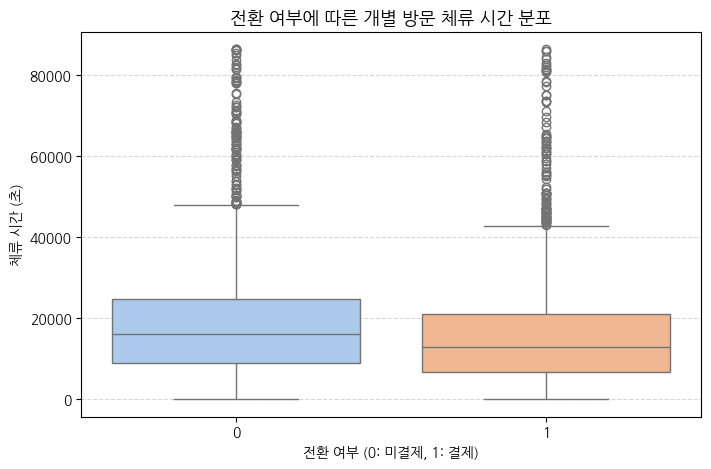

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_payment', y='stay_time_second', data=merged, palette='pastel')
plt.title("전환 여부에 따른 개별 방문 체류 시간 분포", fontsize=13)
plt.xlabel("전환 여부 (0: 미결제, 1: 결제)")
plt.ylabel("체류 시간 (초)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

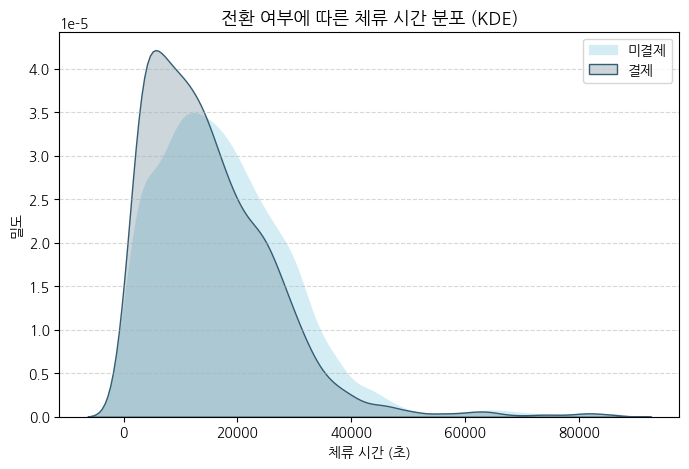

In [ ]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=merged[merged['is_payment']==0]['stay_time_second'], label='미결제', fill=True, color='#d4edf4', alpha=1.0)
sns.kdeplot(data=merged[merged['is_payment']==1]['stay_time_second'], label='결제', fill=True, color='#345c72')
plt.title("전환 여부에 따른 체류 시간 분포 (KDE)", fontsize=13)
plt.xlabel("체류 시간 (초)")
plt.ylabel("밀도")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

- 결제자가 미결제다보다 체류시간이 짧은 경향이 있음
- 피크 위치는 비슷하나 꼬리가 더 두꺼움

/tmp/ipython-input-80-1528722560.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_by_bin = merged.groupby('stay_time_bin')['is_payment'].mean().reset_index()
/tmp/ipython-input-80-1528722560.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='stay_time_bin', y='is_payment', data=conversion_by_bin, palette='Set2')


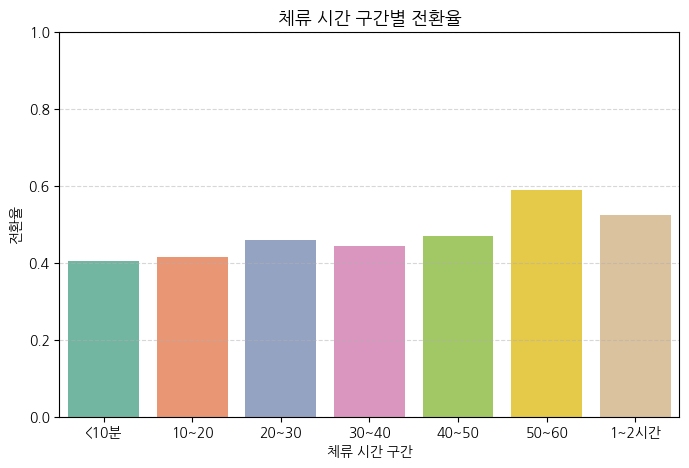

In [ ]:
# 구간 나누기
bins = [0, 600, 1200, 1800, 2400, 3000, 3600, 7200]
labels = ['<10분', '10~20', '20~30', '30~40', '40~50', '50~60', '1~2시간']
merged['stay_time_bin'] = pd.cut(merged['stay_time_second'], bins=bins, labels=labels)

# 구간별 전환율 계산
conversion_by_bin = merged.groupby('stay_time_bin')['is_payment'].mean().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x='stay_time_bin', y='is_payment', data=conversion_by_bin, palette='Set2')
plt.title("체류 시간 구간별 전환율", fontsize=13)
plt.xlabel("체류 시간 구간")
plt.ylabel("전환율")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

- 체류 시간이 길어질수록 전환율이 증가하는 경향, 하지만 큰 차이는 아님
- 중간 구간에 프로모션 집중해볼 수 있음(30 ~ 60분)

- 개별 방문 기준으로, 결제자의 체류시간이 미결제자보다 더 짧은 경향이 관찰됨
- 장시간 체류했다고 해서 반드시 전환되는 것은 아님
- 전반적으로는 체류 시간만으로 결제를 예측하는데 한계가 존재

### visit_hour

In [ ]:
# 1. 그룹핑 및 필터링
hourly_summary = features.groupby('visit_hour')['is_payment'].agg(['mean', 'count']).reset_index()
hourly_summary.columns = ['visit_hour', 'conversion_rate', 'visit_count']
filtered = hourly_summary[hourly_summary['visit_count'] >= 30].copy()
filtered['visit_hour'] = filtered['visit_hour'].astype(int)
filtered = filtered.sort_values('visit_hour')

# 그래프 정렬용 카테고리 변환
filtered['visit_hour'] = pd.Categorical(
    filtered['visit_hour'], categories=range(24), ordered=True
)

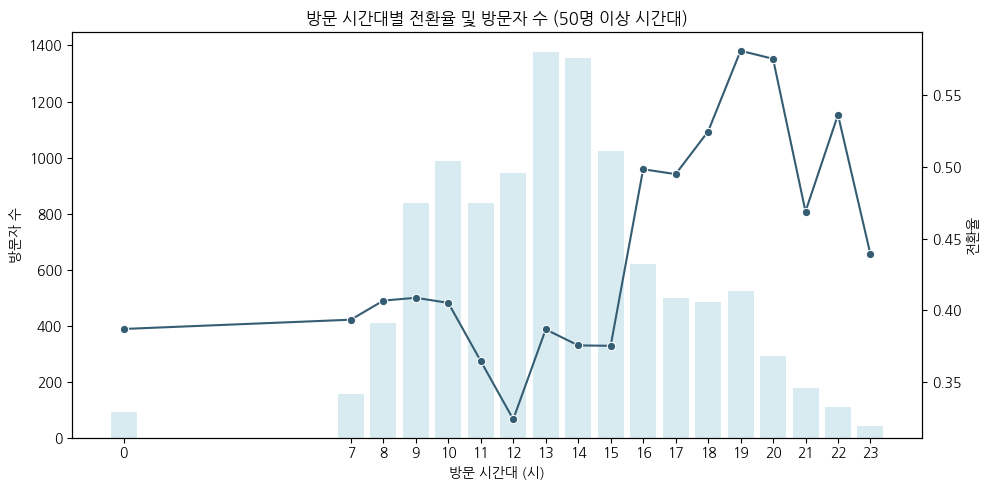

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 막대 그래프 (방문자 수)
color_bar = '#d4edf4'
sns.barplot(
    x='visit_hour', y='visit_count', data=filtered,
    ax=ax1, color=color_bar, zorder=1
)
ax1.set_ylabel('방문자 수', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# 이중 y축 선언
ax2 = ax1.twinx()

# 선 그래프 (전환율)
sns.lineplot(
    x='visit_hour', y='conversion_rate',
    data=filtered.sort_values('visit_hour'),
    ax=ax2, color='#345c72', marker='o', zorder=2
)
ax2.set_ylabel('전환율', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# x축 및 제목
ax1.set_xlabel('방문 시간대 (시)')
ax1.set_xticks(filtered['visit_hour'])
ax1.set_title("방문 시간대별 전환율 및 방문자 수 (50명 이상 시간대)")

plt.tight_layout()
plt.show()

- 방문 시간대별 분석 결과, 13시에 방문자가 가장 많으며
- 9~ 15시가 전체 방문의 중심 시간대
- 반면 20시 이후의 저녁 시간대에는 방문자는 적지만 전환율이 높은 특징
- 이는 저녁 시간대 방문자가 목적 의식이 뚜렷한 체험자일 가능성을 시사
- 따라서 주간 시간대에는 유입 확대 전략, 야간 시간대에는 전환 최적화 전략을 차별적으로 운영하는 것이 효과적

### leave hour

In [ ]:
# 그룹핑 및 필터링
hourly_summary = features.groupby('leave_hour')['is_payment'].agg(['mean', 'count']).reset_index()
hourly_summary.columns = ['leave_hour', 'conversion_rate', 'visit_count']
filtered = hourly_summary[hourly_summary['visit_count'] >= 50].copy()
filtered['leave_hour'] = filtered['leave_hour'].astype(int)
filtered = filtered.sort_values('leave_hour')

# x축 범주형 순서 고정
filtered['leave_hour'] = pd.Categorical(
    filtered['leave_hour'], categories=range(24), ordered=True
)

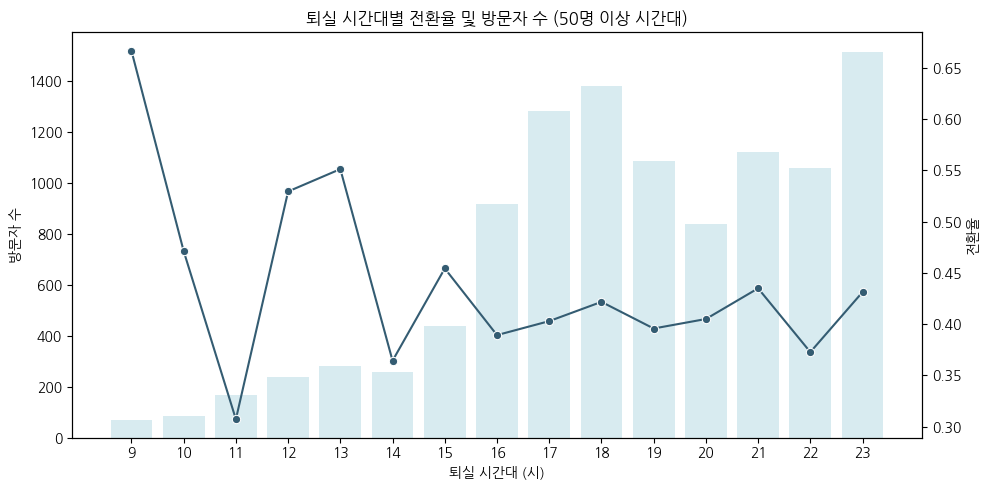

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 막대 그래프: 방문자 수
sns.barplot(
    x='leave_hour', y='visit_count', data=filtered,
    ax=ax1, color='#d4edf4', zorder=1
)
ax1.set_ylabel('방문자 수', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# 이중 y축: 전환율 선 그래프
ax2 = ax1.twinx()
sns.lineplot(
    x='leave_hour', y='conversion_rate', data=filtered.sort_values('leave_hour'),
    ax=ax2, color='#345c72', marker='o', zorder=2
)
ax2.set_ylabel('전환율', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# x축 및 제목
ax1.set_xlabel('퇴실 시간대 (시)')
ax1.set_title("퇴실 시간대별 전환율 및 방문자 수 (50명 이상 시간대)")

# 눈금 간소화 (선택)
ax1.set_xticks(filtered['leave_hour'])

plt.tight_layout()
plt.show()

- 퇴실 시간 기준 분석 결과, 18시에 퇴실한 고객의 수가 가장 많음
- 업무 목적으로 사용하는 유저일 가능성이 있음
- 오전 시간에는 전환율이 가장 낮거나 가장 높은 것 확인
- 퇴실자가 적어서 데이터 불균형으로 극단값들을 보일 가능성 있음
- 전환 보다는 퇴실자가 가장 많은 18시 전후 집중 응대 및 전환 유도 전략이 효과적

### visit_weekday

In [ ]:
# 요약 테이블 만들기
weekday_summary = features.groupby('visit_weekday')['is_payment'].agg(['mean', 'count']).reset_index()
weekday_summary.columns = ['visit_weekday', 'conversion_rate', 'visit_count']

In [ ]:
# 0:월, 1:화, ..., 6:일
weekday_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
weekday_summary['weekday_label'] = weekday_summary['visit_weekday'].map(weekday_map)

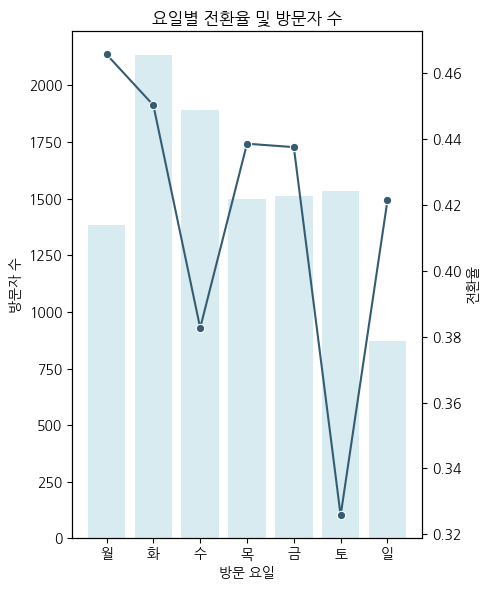

In [ ]:
fig, ax1 = plt.subplots(figsize=(5, 6))

# 막대 그래프: 방문자 수
sns.barplot(x='weekday_label', y='visit_count',
            data=weekday_summary, ax=ax1,
            color='#d4edf4', zorder=1)
ax1.set_ylabel('방문자 수', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# 이중 y축
ax2 = ax1.twinx()

# 선 그래프: 전환율
sns.lineplot(x='weekday_label', y='conversion_rate',
             data=weekday_summary, marker='o',
             ax=ax2, color='#345c72', zorder=2)
ax2.set_ylabel('전환율', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 제목, x축
ax1.set_xlabel('방문 요일')
ax1.set_title('요일별 전환율 및 방문자 수')

plt.tight_layout()
plt.show()

- 화요일 방문자 수와 전환율 모두 가장 높게 나옴
- 토요일은 방문자는 적지 않음에도 전환율이 가장 낮음
- 일요일은 방문자 수가 가장 적지만 전환율은 상대적으로 높음
- 화요일 집중 운영, 토요일 전환 개선, 일요일 타겟 유입 확대 전략

## 인사이트

1. 시간대 기반 전략
- 18시 퇴실자 수가 가장 많음 -> 6시에 퇴장하는 공유 오피스 사용자? 업무용으로 방문한 경우가 높지 않을까?
    - 18시에 퇴실하는 유저 기반으로 추후 회의실 1시간 무료 이용권 증정
    - 퇴실 후 1시간 이내 자동 메시지 발송
    - ex. "오늘 어떠셨나요? 내일은 미팅룸 1시간 무료 쿠폰 드릴게요"
- 21시 이후 방문자 전환율 높음
    - 예약 사이트나 어플 상단에 야간 체험 가능성 강조
    - ex. "늦게까지도 운영돼요!"
    - 야간 예약자에게 전용 리마인드 메시지
    - ex. "내일도 조용히 일하고 싶다면? 지금 결제하고 자리 확보하세요!"
- 체류 시간이 너무 길면 오히려 전환 낮음

2. 요일 기반 전략
- 화요일: 방문자 수와 전환율 모두 최고 -> 광고/이벤트 집중 요일로 선정
    - ex. 화요일 방문 예약 시, 특별 혜택 제공
- 토용리: 방문자 수는 중상위지만 전환율 최저 -> 토요일 방문자에겐 후속 리마인드 메시지 강화
    - ex. 토요일 방문 감사드려요! 이틀 안에 결제 시 혜택 드려요"

- 18시 퇴실자는 업무형 사용자가 많아 결제 전환 가능성이 높음 -> 이 타이밍에 맞춘 퇴장 직후 리마인드 or 혜택 재공 필요
- 야간 체험자는 목적성 강한 고전환 유저로, 야간 운영 가능성을 노출하고 전용 혜택 제공 전략 유효
- 화요일은 전환 효율 최고 요일로, 마케팅/상담 리소스 집중 타이밍으로 적합
- 토요일은 방문 대비 전환 저조 -> 후속 커뮤니케이션 강화 및 짧고 명확한 체험 가이드 제공 전략 필요

# 공유오피스 체험 유저 행동패턴 분석 및 결제 예측 모델 개발 보고서

## 1. 프로젝트 개요

본 프로젝트는 공유오피스 체험 프로그램을 이용한 사용자 데이터를 분석하여, 체험 이후 실제 결제로 이어지는 사용자들의 행동 패턴을 파악하고 이를 기반으로 결제 가능성을 예측하는 모델을 개발하는 것을 목표로 합니다. 이를 통해 사용자 행동 이해를 높이고, 타겟 마케팅 및 서비스 개선에 활용하여 전환율을 극대화하는 데 기여하고자 합니다.

## 2. 문제 정의 및 모델링 목표

- **문제:** 공유오피스 체험 신청 사용자 중 실제 결제로 전환되는 사용자 비율이 낮으며, 어떤 사용자가 결제로 이어질 가능성이 높은지 예측하기 어렵습니다.
- **모델링 목표:** 체험 신청 이후 방문 기록이 있는 사용자를 대상으로, 방문 행동 데이터(신청일시, 입실시간, 체류시간, 방문 횟수 등)를 활용하여 결제 여부를 예측하는 분류 모델을 개발합니다.

## 3. 데이터 분석 및 피처 엔지니어링

- `trial_visit_info.csv`, `trial_register.csv`, `trial_payment.csv` 세 가지 데이터셋을 병합하여 분석에 사용했습니다.
- 데이터 전처리 과정에서 방문 기록이 없는 사용자 1262명을 제외하고, 입실 시간이 잘못 기록된 사용자 759명을 추가로 제외했습니다. 최종 분석 대상은 10826명의 사용자입니다.
- 주요 피처 엔지니어링 내용은 다음과 같습니다.
    - `visit_count`: 체험 신청 후 방문 횟수
    - `stay_time_avg`: 평균 체류 시간(초)
    - `first_visit_gap`: 신청일과 첫 방문일 간 차이
    - `early_visit`: 신청 후 3일 내 방문 여부 (원핫인코딩)
    - `visit_time_slot`: 주로 입실한 시간대 (오전/오후/야간) (원핫인코딩)
    - `visit_hour`: 입실 시간
    - `leave_hour`: 퇴실 시간
    - `visit_weekday`: 평일/주말 방문
    - `stay_time_bin`: 체류 시간 구간화 (원핫인코딩)
    - `is_weekend`: 주말 방문 여부

## 4. 모델링 및 성능 평가

다양한 분류 모델을 시도하고 성능을 비교했습니다.

- **로지스틱 회귀:** 피처 간 선형 관계가 낮아 모델 성능이 좋지 않았습니다.
- **결정 트리, 배깅, 랜덤 포레스트:** 비선형 관계를 잘 포착하는 앙상블 모델을 사용했습니다.
- **모델 성능 향상 시도:** 파생변수 추가, Stratify K-Fold 적용, 클래스 가중치 부여, Grid Search를 통한 하이퍼파라미터 튜닝을 시도했습니다.

| 모델(배깅)                      | Accuracy | ROC AUC | Recall | Precision | f1-score |
|---------------------------|----------|---------|--------|-----------|----------|
| 기본 Bagging             | 0.78     | 0.84    | 0.66   | 0.78      | 0.72     |
| + 파생변수 추가           | 0.79     | 0.84    | 0.67   | 0.77      | 0.72     |
| + Stratify                | 0.79     | 0.85    | 0.68   | 0.78      | 0.73     |
| + Class Weight            | 0.79     | 0.85    | 0.67   | 0.79      | 0.72     |
| + GridSearch Best         | 0.79     | 0.85    | 0.68   | 0.78      | 0.73     |

| 모델 (랜덤 포레스트)                      | Accuracy | ROC AUC | Recall | Precision | f1-score |
|---------------------------|----------|---------|--------|-----------|----------|
| 기본 RF                  | 0.78     | 0.83    | 0.66   | 0.78      | 0.71     |
| + 파생변수 추가           | 0.73     | 0.81    | 0.60   | 0.70      | 0.65     |
| + Stratify                | 0.74     | 0.81    | 0.61   | 0.73      | 0.67     |
| + Class Weight            | 0.76     | 0.82    | 0.62   | 0.75      | 0.68     |
| + GridSearch Best         | 0.75     | 0.82    | 0.62   | 0.74      | 0.68     |

**결론:** Bagging 모델이 Grid Search를 적용했을 때 가장 높은 F1-score (0.73)와 우수한 ROC AUC (0.85) 값을 보였습니다. 이는 Bagging 모델이 공유오피스 체험 유저의 결제 여부를 예측하는 데 가장 적합한 모델임을 시사합니다.

## 5. 주요 피처 중요도 및 인사이트

Bagging 모델의 피처 중요도 분석 및 EDA를 통해 다음과 같은 주요 인사이트를 도출했습니다.

| 변수명                                | 중요도 해석                            | 비즈니스 인사이트                                       |
| ---------------------------------- | --------------------------------- | --------------------------------------------------- |
| `stay_time_avg`                    | 가장 중요함. 한 사람의 평균 체류 시간이 예측에 크게 기여 | 체류시간이 긴 사람일수록 전환 가능성 높음 → 매장 내 머무는 시간 늘릴 수 있는 전략 필요 |
| `stay_time_second`                 | 두 번째로 중요. 개별 방문의 체류시간도 영향 있음      | 단발 방문이라도 오래 체류하면 전환 가능성↑                            |
| `leave_hour` / `visit_hour`        | 방문 시간대 (입장/퇴장)이 전환과 관련 있음         | 특정 시간대(예: 오전 or 오후)에 방문한 사람을 타겟팅                    |
| `visit_weekday`                    | 요일 정보도 영향 있음                      | 주말 or 특정 요일 방문자 전환율 분석해볼 수 있음                       |
| `visit_count`                      | 방문 횟수는 다소 영향 있음                   | 많이 오는 사람보단, 오랜 시간 머무는 사람에게 집중?                       |
| `first_visit_gap`                  | 신청 후 처음 방문까지의 간격                  | 빠르게 방문한 사람 전환 가능성 분석 가능

**주요 인사이트 요약:**

- **체류 시간:** 체류 시간이 길수록 전환율이 높아지는 경향이 있지만, 특정 시간 이상(평균 138분~247분 구간) 체류하는 경우 오히려 전환율이 낮아지는 현상이 관찰되었습니다. 이는 **적정 체류 시간**을 유도하는 전략이 중요함을 시사합니다.
- **시간대:** 18시 퇴실 사용자가 많으며, 이들은 업무 목적으로 방문했을 가능성이 높습니다. 야간(21시 이후) 방문자는 방문자 수는 적지만 전환율이 높습니다. 주간에는 유입 확대, 야간에는 전환 최적화 전략이 필요합니다.
- **요일:** 화요일은 방문자와 전환율 모두 가장 높은 요일이며, 토요일은 방문자는 많지만 전환율이 가장 낮습니다. 화요일에는 마케팅 집중, 토요일에는 후속 커뮤니케이션 강화 전략이 효과적입니다.

## 6. 결론 및 향후 과제

본 프로젝트를 통해 공유오피스 체험 유저의 결제 전환에 영향을 미치는 주요 행동 패턴을 파악하고, 이를 예측하는 Bagging 모델을 개발했습니다. 도출된 인사이트는 실제 비즈니스 전략 수립에 활용될 수 있습니다.

향후 과제로는 다음과 같은 내용을 고려할 수 있습니다.

- 더 다양한 피처 (예: 사용자의 서비스 이용 기록, 설문 응답 등) 활용
- 다른 고급 모델 (예: LightGBM, XGBoost) 적용 및 비교
- 모델 해석력 강화 (SHAP, LIME 등 활용)
- 예측 결과를 기반으로 한 개인 맞춤형 추천 시스템 개발

이 보고서가 공유오피스 체험 프로그램의 전환율 개선에 기여하고, 데이터 기반 의사결정을 위한 유용한 자료가 되기를 바랍니다.

---

### 모델 선택 이유

저희는 공유오피스 체험 유저의 결제 전환 여부를 예측하기 위해 여러 분류 모델을 검토했습니다. 초기 분석 단계에서 로지스틱 회귀와 같은 선형 모델로는 피처들과 결제 여부 간의 복잡한 비선형 관계를 충분히 포착하기 어렵다고 판단했습니다.

따라서 다음과 같은 비선형 모델들을 선택하고 비교 분석했습니다.

1.  **결정 트리 (Decision Tree):**
    *   **이유:** 결정 트리는 데이터의 복잡한 규칙과 패턴을 직관적으로 파악하는 데 용이합니다. 체험 유저의 다양한 행동 패턴(체류 시간, 방문 시간대 등)이 결제 여부에 미치는 영향을 규칙 기반으로 이해하는 데 도움이 될 것이라고 생각했습니다. 초기 모델로 빠르게 패턴을 확인하고 피처 중요도를 파악하는 데 사용했습니다.
    *   **장점:** 모델의 작동 방식을 이해하기 쉽고, 시각화가 용이하여 비즈니스 담당자에게 결과를 설명하기 편리합니다.
    *   **한계:** 단일 결정 트리는 데이터의 작은 변화에도 민감하게 반응하여 과적합(Overfitting)될 위험이 있습니다.

2.  **배깅 (Bagging - Bootstrap Aggregating):**
    *   **이유:** 결정 트리의 과적합 문제를 개선하고 모델의 안정성 및 예측 성능을 높이기 위해 배깅 기법을 도입했습니다. 배깅은 여러 개의 결정 트리를 학습시킨 후 결과를 집계(예: 다수결 투표)하여 최종 예측을 수행합니다.
    *   **장점:** 단일 모델보다 일반화 성능이 뛰어나고, 분산(Variance)을 감소시켜 과적합을 줄이는 효과가 있습니다.
    *   **작동 방식:** 원본 데이터셋에서 여러 개의 부트스트랩 샘플을 생성하고, 각 샘플에 대해 독립적으로 결정 트리를 학습시킵니다.

3.  **랜덤 포레스트 (Random Forest):**
    *   **이유:** 배깅에서 더 나아가 모델의 다양성을 극대화하고 성능을 추가적으로 향상시키기 위해 랜덤 포레스트를 사용했습니다. 랜덤 포레스트는 배깅과 마찬가지로 여러 개의 결정 트리를 사용하지만, 각 트리를 학습할 때 전체 피처 중 일부만을 무작위로 선택하여 사용합니다.
    *   **장점:** 배깅의 장점(분산 감소)에 더해 피처의 무작위 선택을 통해 각 트리 간의 상관관계를 낮추어 예측 오류를 더 효과적으로 줄입니다. 일반적으로 배깅보다 뛰어난 성능을 보이는 경우가 많습니다.
    *   **작동 방식:** 부트스트랩 샘플링과 더불어 피처 무작위 선택을 통해 각 트리를 학습시킵니다. 이를 통해 다양한 관점에서 데이터를 학습한 트리들의 앙상블을 구성합니다.

최종적으로, 저희는 이 세 모델의 성능을 비교하고 Grid Search 등을 통해 최적의 하이퍼파라미터를 탐색한 결과, **배깅 모델**이 해당 데이터셋에서 가장 안정적이고 우수한 예측 성능(특히 ROC AUC와 F1-score 측면)을 보였기 때문에 최종 모델로 선정했습니다. 각 모델의 특성을 이해하고 데이터의 성격에 맞는 모델을 탐색하는 과정을 거쳤음을 강조할 수 있습니다.

---

### 모델 성능 향상 방법 적용 이유

모델의 예측 성능을 최대한 끌어올리고 데이터의 특성을 더 잘 반영하기 위해 다음과 같은 다양한 성능 향상 기법들을 적용하고 그 효과를 비교했습니다. 각 방법은 특정 문제를 해결하거나 모델의 예측력을 개선하기 위한 명확한 목적을 가집니다.

1.  **파생 변수 추가 (Feature Engineering):**
    *   **이유:** 기존 데이터만으로는 모델이 결제 여부를 예측하기에 충분한 정보를 담고 있지 않을 수 있습니다. 사용자의 행동 패턴을 더 잘 나타내는 새로운 변수를 만듦으로써 모델이 데이터의 숨겨진 패턴을 학습하는 데 도움을 주고자 했습니다. 예를 들어, 단순히 방문 시간보다는 '평균 체류 시간'이나 '방문 시간대(오전/오후/야간)'와 같은 변수가 사용자의 이용 목적이나 만족도를 더 잘 반영할 수 있습니다.
    *   **기대 효과:** 모델의 설명력을 높이고, 예측 성능을 향상시킬 수 있습니다.

2.  **Stratify K-Fold 교차 검증:**
    *   **이유:** 저희 데이터셋은 결제(1)보다 미결제(0) 사용자가 더 많은 불균형 데이터입니다. 단순히 데이터를 무작위로 나누면 학습/테스트 세트 간에 결제/미결제 비율이 크게 달라져 모델이 특정 클래스에 편향될 수 있습니다. Stratify 옵션은 데이터를 나눌 때 원래 데이터셋의 클래스 비율을 유지시켜, 각 폴드(Fold)나 분할된 데이터셋이 전체 데이터의 특성을 잘 대표하도록 합니다.
    *   **기대 효과:** 모델 학습 시 데이터 편향을 줄이고, 모델 평가 결과의 신뢰성을 높일 수 있습니다. 불균형 데이터 문제에 강건한 모델을 만들 수 있습니다.

3.  **클래스 가중치 부여 (Class Weight):**
    *   **이유:** 데이터 불균형 문제의 또 다른 해결 방법입니다. 모델 학습 시 상대적으로 적은 클래스(저희의 경우 결제 사용자)의 오류에 더 큰 가중치를 부여하여, 모델이 소수 클래스를 더 중요하게 학습하도록 유도합니다. 이를 통해 모델이 결제 사용자를 놓치는 것(Recall)을 줄이는 데 집중할 수 있습니다.
    *   **기대 효과:** 특히 소수 클래스(결제)에 대한 예측 성능(Recall, Precision, F1-score)을 개선할 수 있습니다.

4.  **Grid Search를 통한 하이퍼파라미터 튜닝:**
    *   **이유:** 결정 트리, 배깅, 랜덤 포레스트와 같은 모델은 `n_estimators`, `max_depth`, `min_samples_split`, `class_weight` 등 다양한 하이퍼파라미터 값에 따라 성능이 크게 달라집니다. 이러한 하이퍼파라미터는 모델이 학습하는 방식이나 복잡성을 조절하는데, 최적의 조합을 찾지 못하면 모델이 과적합되거나 과소적합될 수 있습니다. Grid Search는 사전에 정의된 하이퍼파라미터 값들의 조합을 모두 탐색하여 가장 좋은 성능을 내는 조합을 찾아주는 자동화된 기법입니다.
    *   **기대 효과:** 모델의 잠재적인 최고 성능을 발휘하도록 최적의 설정을 찾고, 모델의 일반화 성능을 향상시킬 수 있습니다.

이러한 다양한 방법들을 체계적으로 적용하고 그 결과를 비교함으로써, 데이터의 특성을 최대한 활용하고 가장 신뢰할 수 있는 예측 모델을 구축하고자 노력했습니다. 특히 데이터 불균형 문제에 대응하기 위한 Stratify와 Class Weight 적용, 그리고 모델의 최적 설정을 찾기 위한 Grid Search가 중요한 역할을 했습니다.

---

### 원본 변수와 파생 변수 구분

본 분석에서는 제공된 원본 데이터셋(`trial_visit_info.csv`, `trial_register.csv`, `trial_payment.csv`)의 변수들을 활용하고, 모델의 예측 성능 향상을 위해 사용자의 행동 패턴을 기반으로 새로운 파생 변수들을 생성했습니다.

**원본 변수 (Original Features):**

*   **`trial_date`**: 체험 신청일
*   **`user_uuid`**: 사용자 고유 식별자
*   **`site_id`**: 방문한 공유오피스 지점 ID
*   **`date`**: 실제 방문일
*   **`stay_time`**: 방문 시 체류 시간 (문자열 형태)
*   **`stay_time_second`**: 방문 시 체류 시간 (초 단위)
*   **`first_enter_time`**: 방문 시 입실 시간
*   **`last_leave_time`**: 방문 시 퇴실 시간
*   **`is_payment`**: 결제 여부 (타겟 변수)

**파생 변수 (Engineered Features):**

원본 변수들을 조합하거나 변환하여 사용자의 행동 특성을 더 잘 나타내기 위해 생성된 변수들입니다.

*   **`visit_count`**: 체험 신청 후 해당 사용자의 총 방문 횟수
    *   (`date` 변수를 `user_uuid` 별로 그룹핑하여 계산)
*   **`stay_time_avg`**: 해당 사용자의 평균 체류 시간 (초)
    *   (`stay_time_second` 변수를 `user_uuid` 별로 그룹핑하여 평균 계산)
*   **`first_visit_gap`**: 체험 신청일(`trial_date`)과 첫 방문일(`date` 중 최소값) 간의 일수 차이
*   **`early_visit`**: `first_visit_gap`이 3일 이하인지 여부 (신청 후 빠르게 방문했는지)
    *   (이진 변수로 변환)
*   **`visit_time_slot`**: 첫 방문 입실 시간(`first_enter_time`)을 기준으로 구분한 시간대 (오전/오후/야간)
    *   (범주형 변수, 모델 학습을 위해 원핫 인코딩 적용)
*   **`visit_hour`**: 첫 방문 입실 시간(`first_enter_time`)의 시간 정보 (0-23)
*   **`leave_hour`**: 첫 방문 퇴실 시간(`last_leave_time`)의 시간 정보 (0-23)
*   **`visit_weekday`**: 첫 방문일(`date`)의 요일 정보 (월=0, 일=6)
*   **`stay_time_bin`**: 개별 방문 체류 시간(`stay_time_second`)을 구간화한 변수 (<10분, 10~20분 등)
    *   (범주형 변수로 변환 후 모델 학습에 사용)
*   **`is_weekend`**: 첫 방문일(`date`)이 주말(토/일)인지 여부
    *   (이진 변수로 변환)

이러한 파생 변수들을 통해 사용자의 방문 빈도, 체류 특성, 시간대별/요일별 방문 패턴 등 다양한 행동 양식을 모델이 학습할 수 있도록 데이터를 풍부하게 만들었습니다.

| 모델(배깅)                      | Accuracy | ROC AUC | Recall | Precision | f1-score |
|---------------------------|----------|---------|--------|-----------|----------|
| 기본 Bagging             | 0.78     | 0.84    | 0.66   | 0.78      | 0.72     |
| + 파생변수 추가           | 0.79     | 0.84    | 0.67   | 0.77      | 0.72     |
| + Stratify                | 0.79     | 0.85    | 0.68   | 0.78      | 0.73     |
| + Class Weight            | 0.79     | 0.85    | 0.67   | 0.79      | 0.72     |
| + GridSearch Best         | 0.79     | 0.85    | 0.68   | 0.78      | 0.73     |

| 모델 (랜덤 포레스트)                      | Accuracy | ROC AUC | Recall | Precision | f1-score |
|---------------------------|----------|---------|--------|-----------|----------|
| 기본 RF                  | 0.78     | 0.83    | 0.66   | 0.78      | 0.71     |
| + 파생변수 추가           | 0.73     | 0.81    | 0.60   | 0.70      | 0.65     |
| + Stratify                | 0.74     | 0.81    | 0.61   | 0.73      | 0.67     |
| + Class Weight            | 0.76     | 0.82    | 0.62   | 0.75      | 0.68     |
| + GridSearch Best         | 0.75     | 0.82    | 0.62   | 0.74      | 0.68     |